### Knapsack Problem


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from qiskit_optimization.applications import Knapsack, Maxcut
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector

from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')

estimator = BackendEstimator(backend=backend, options={'shots': 1000})

In [3]:
from pce import *
from qubo_to_maxcut import *

In [4]:
# the graph
import networkx as nx
import matplotlib.pyplot as plt
def create_graph_from_weight_matrix(w):
    G = nx.Graph()
    n = len(w)

    # Add nodes
    for i in range(n):
        G.add_node(i)

    # Add edges with weights, ignoring zero-weight edges
    for i in range(n):
        for j in range(i + 1, n):
            if w[i, j] != 0:
                G.add_edge(i, j, weight=w[i, j])

    return G

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

### Generating Random Instance

In [5]:
# Parameters for the knapsack problem
num_items = 5
max_weight = 10

# Generate random weights and values for the items

weights = np.random.randint(1, 10, size=num_items)
values = np.random.randint(10, 50, size=num_items)

# Capacity of the knapsack
capacity = int(0.6 * np.sum(weights))

print(f"Weights: {weights}")
print(f"Values: {values}")
print(f"Capacity: {capacity}")

# Create the Knapsack problem
knapsack = Knapsack(values.tolist(), weights.tolist(), capacity)

# Convert the problem to a QuadraticProgram
problem = knapsack.to_quadratic_program()
print(problem.prettyprint())

Weights: [5 4 9 7 1]
Values: [43 18 31 14 40]
Capacity: 15
Problem name: Knapsack

Maximize
  43*x_0 + 18*x_1 + 31*x_2 + 14*x_3 + 40*x_4

Subject to
  Linear constraints (1)
    5*x_0 + 4*x_1 + 9*x_2 + 7*x_3 + x_4 <= 15  'c0'

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



### Exact Solution

In [6]:
# Solve the problem using CplexOptimizer
optimizer = CplexOptimizer()
result = optimizer.solve(problem)

print("Solution:")
print(result.fval)
print(result.x)

Solution:
114.0
[1. 0. 1. 0. 1.]


### Converting to QUBO

In [7]:
# convert problem to a QUBO
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Minimize
 obj: - 22093 x_0 - 17658 x_1 - 39721 x_2 - 30884 x_3 - 4450 x_4
      - 4410 c0@int_slack@0 - 8820 c0@int_slack@1 - 17640 c0@int_slack@2
      - 35280 c0@int_slack@3 + [ 7350 x_0^2 + 11760 x_0*x_1 + 26460 x_0*x_2
      + 20580 x_0*x_3 + 2940 x_0*x_4 + 2940 x_0*c0@int_slack@0
      + 5880 x_0*c0@int_slack@1 + 11760 x_0*c0@int_slack@2
      + 23520 x_0*c0@int_slack@3 + 4704 x_1^2 + 21168 x_1*x_2 + 16464 x_1*x_3
      + 2352 x_1*x_4 + 2352 x_1*c0@int_slack@0 + 4704 x_1*c0@int_slack@1
      + 9408 x_1*c0@int_slack@2 + 18816 x_1*c0@int_slack@3 + 23814 x_2^2
      + 37044 x_2*x_3 + 5292 x_2*x_4 + 5292 x_2*c0@int_slack@0
      + 10584 x_2*c0@int_slack@1 + 21168 x_2*c0@int_slack@2
      + 42336 x_2*c0@int_slack@3 + 14406 x_3^2 + 4116 x_3*x_4
      + 4116 x_3*c0@int_slack@0 + 8232 x_3*c0@int_slack@1
      + 16464 x_3*c0@int_slack@2 + 32928 x_3*c0@int_slack@3 + 294 x_4^2
      + 588 x_4*c0@int_slac

Now there are two methods we can do:

1. Convert this QUBO into a weighted Max Cut and solve it using PCE with Max Cut Loss function
2. Solve this QUBO with PCE that has the updated QUBO loss function


Let's look at the first step

#### Coverting QUBO to a Weighted Max Cut

In [8]:
linear = qubo.objective.linear.to_array()
quadratic = qubo.objective.quadratic.to_array()

In [9]:
weight_max_cut_qubo = QUBO(quadratic, linear)
weight_max_cut_qubo.linear_to_square()
max_cut_graph = weight_max_cut_qubo.to_maxcut()
print(max_cut_graph)

[[    0. 16084. 12900. 29044. 22610.  3154.  3234.  6468. 12936. 25872.]
 [16084.     0.  5880. 13230. 10290.  1470.  1470.  2940.  5880. 11760.]
 [12900.  5880.     0. 10584.  8232.  1176.  1176.  2352.  4704.  9408.]
 [29044. 13230. 10584.     0. 18522.  2646.  2646.  5292. 10584. 21168.]
 [22610. 10290.  8232. 18522.     0.  2058.  2058.  4116.  8232. 16464.]
 [ 3154.  1470.  1176.  2646.  2058.     0.   294.   588.  1176.  2352.]
 [ 3234.  1470.  1176.  2646.  2058.   294.     0.   588.  1176.  2352.]
 [ 6468.  2940.  2352.  5292.  4116.   588.   588.     0.  2352.  4704.]
 [12936.  5880.  4704. 10584.  8232.  1176.  1176.  2352.     0.  9408.]
 [25872. 11760.  9408. 21168. 16464.  2352.  2352.  4704.  9408.     0.]]


Make the Max Cut LP 

In [10]:
max_cut = Maxcut(max_cut_graph)
problem_max_cut = max_cut.to_quadratic_program()
print(problem_max_cut.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 132302 x_0 + 69004 x_1 + 56412 x_2 + 113716 x_3 + 92582 x_4 + 14914 x_5
      + 14994 x_6 + 29400 x_7 + 56448 x_8 + 103488 x_9 + [ - 64336 x_0*x_1
      - 51600 x_0*x_2 - 116176 x_0*x_3 - 90440 x_0*x_4 - 12616 x_0*x_5
      - 12936 x_0*x_6 - 25872 x_0*x_7 - 51744 x_0*x_8 - 103488 x_0*x_9
      - 23520 x_1*x_2 - 52920 x_1*x_3 - 41160 x_1*x_4 - 5880 x_1*x_5
      - 5880 x_1*x_6 - 11760 x_1*x_7 - 23520 x_1*x_8 - 47040 x_1*x_9
      - 42336 x_2*x_3 - 32928 x_2*x_4 - 4704 x_2*x_5 - 4704 x_2*x_6
      - 9408 x_2*x_7 - 18816 x_2*x_8 - 37632 x_2*x_9 - 74088 x_3*x_4
      - 10584 x_3*x_5 - 10584 x_3*x_6 - 21168 x_3*x_7 - 42336 x_3*x_8
      - 84672 x_3*x_9 - 8232 x_4*x_5 - 8232 x_4*x_6 - 16464 x_4*x_7
      - 32928 x_4*x_8 - 65856 x_4*x_9 - 1176 x_5*x_6 - 2352 x_5*x_7
      - 4704 x_5*x_8 - 9408 x_5*x_9 - 2352 x_6*x_7 - 4704 x_6*x_8 - 9408 x_6*x_9
      - 9408 x_7*x_8 - 18816 x_7*x_9 - 37632 x

Let's visualize the graph

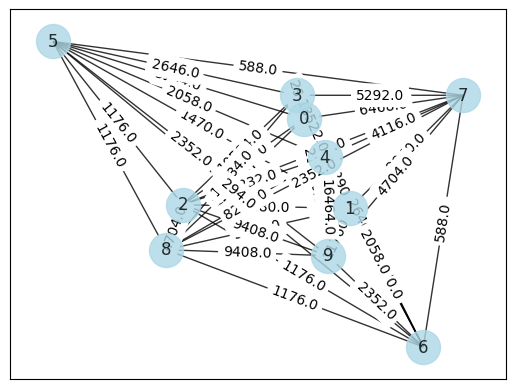

In [11]:
graph = create_graph_from_weight_matrix(max_cut_graph)
draw_graph(graph, "lightblue", nx.spring_layout(graph))

In [12]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (quadratic or cubic)
num_qubits = pauli_encoder.find_n(problem_max_cut.get_num_binary_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits,problem_max_cut.get_num_binary_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")



We can encode the problem with 4 qubits using 10 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXII', 'XIXI', 'XIIX', 'IXXI', 'IXIX', 'IIXX', 'YYII', 'YIYI', 'YIIY', 'IYYI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


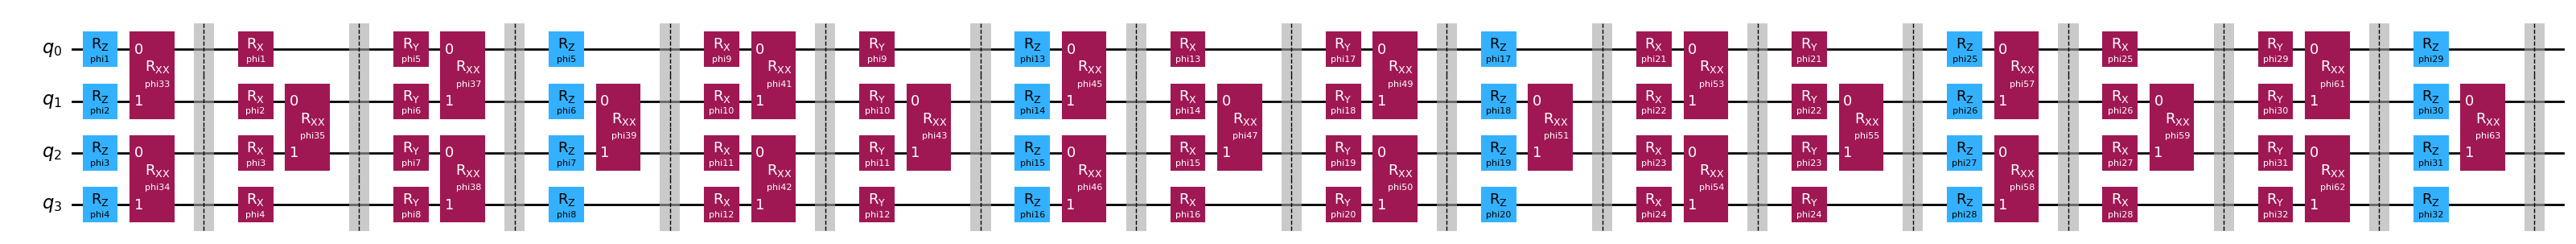

In [13]:
depth = 8
# num_nodes = graph.number_of_nodes()
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl',fold=-1)

In [14]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                qp = problem_max_cut,
                                graph=graph,
                                num_qubits=num_qubits,
                                k=k,
                                max_cut_graph=max_cut_graph,
                                method='exact', 
                                loss_method='maxcut',
                                multi_op=False)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut


In [15]:
maxiter = 30
from qiskit_algorithms.optimizers import COBYLA,SLSQP,POWELL
optimizer = SLSQP(maxiter=maxiter)
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)


Single Optimization


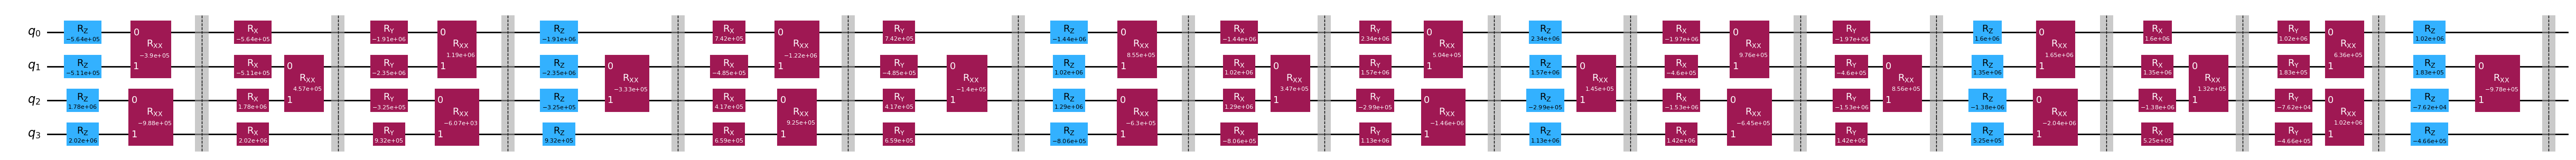

In [16]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl',fold=-1)

In [17]:
psi_final = Statevector(final_ansatz)

In [18]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
max_cut_utility = MaxCutUtility(max_cut_graph)
initial_score, max_cut_solution_pce = max_cut_utility.evaluate_initial_score(psi_final, pauli_strings)
print(f"Initial score: {initial_score}")
print(f"Max cut solution: {max_cut_solution_pce}")

Initial score: 132566.0
Max cut solution: [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]


In [19]:
# convert to QUBO cost
qubo_solution_string = max_cut_utility.max_cut_to_qubo_solution(max_cut_solution_pce)
# get the qubo cost from the string
qubo_cost = qubo.objective.evaluate(qubo_solution_string)
print(f"QUBO cost: {qubo_cost}")
print(f"Qubo Solution Bitstring: {qubo_solution_string}")

QUBO cost: 32943.0
Qubo Solution Bitstring: [1, 1, 1, 0, 1, 1, 1, 0, 1]


In [20]:

result_initial = converter.interpret(qubo_solution_string)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 132.0
Initial Knapsack solution          : [1. 1. 1. 0. 1.]
Initial Knapsack solution feasible : False


### Bit Swap

In [21]:
optimized_bitstring, final_cost = max_cut_utility.bit_swap_search(qubo, bitstring=qubo_solution_string)
print("Optimized bitstring:", optimized_bitstring)
print("Final cost:", final_cost)

Starting cost: 32943.0
Bit flip: Improved solution by flipping bit 0: Cost = 14611.0
Bit flip: Improved solution by flipping bit 1: Cost = 5221.0
Bit flip: Improved solution by flipping bit 2: Cost = 1283.0
Bit flip: Improved solution by flipping bit 7: Cost = 107.0
Multi-bit flip: Improved solution by flipping bits (1, 7): Cost = 89.0
Multi-bit flip: Improved solution by flipping bits (3, 8): Cost = -72.0
Multi-bit flip: Improved solution by flipping bits (0, 1, 5): Cost = -97.0
Multi-bit flip: Improved solution by flipping bits (2, 3, 6): Cost = -114.0
Final best cost: -114.0
Optimized bitstring: [1, 0, 1, 0, 1, 0, 0, 0, 0]
Final cost: -114.0


In [22]:

result_initial = converter.interpret(optimized_bitstring)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 114.0
Initial Knapsack solution          : [1. 0. 1. 0. 1.]
Initial Knapsack solution feasible : True


### QUBO Loss 

The second method is making use of PCE with QUBO loss function

In [23]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (quadratic or cubic)
num_qubits = pauli_encoder.find_n(qubo.get_num_binary_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits,qubo.get_num_binary_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")



We can encode the problem with 3 qubits using 9 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXI', 'XIX', 'IXX', 'YYI', 'YIY', 'IYY', 'ZZI', 'ZIZ', 'IZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


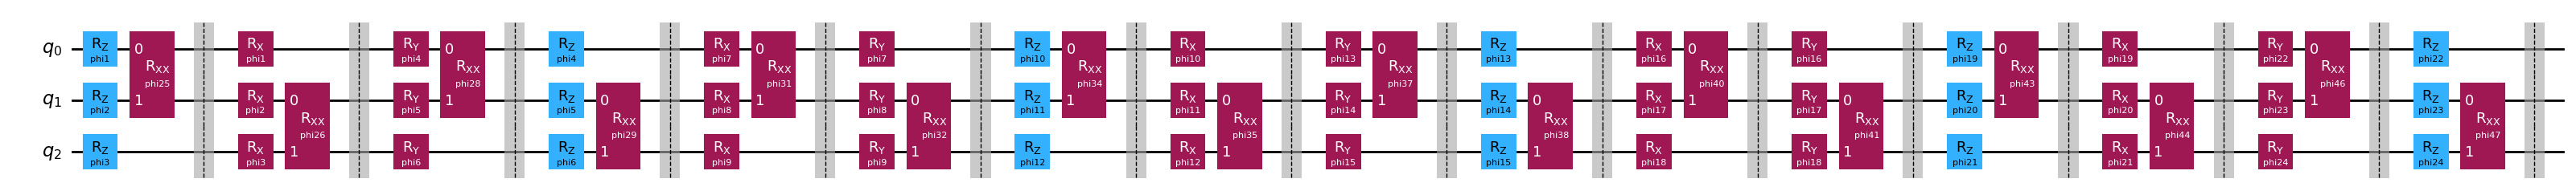

In [24]:
depth = 8
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl',fold=-1)

In [25]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                num_qubits=num_qubits,
                                k=k,
                                method='exact', 
                                loss_method='qubo',
                                qubo=qubo,
                                multi_op=True,
                                steps = 5)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut



In [26]:
maxiter = 30
from qiskit_algorithms.optimizers import SLSQP
optimizer =SLSQP(maxiter=maxiter)
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)


Multi Reoptimization

--- Optimization Round 1 ---
Best QUBO cost: inf
QUBO cost: -72.0
Improvement: inf
Improvement detected! Best QUBO cost updated: -72.0
Consecutive no-improvement rounds: 0. Rounds remaining before stopping: 5.

--- Optimization Round 2 ---
Best QUBO cost: -72.0
QUBO cost: 76.0
No improvement detected.
No improvement in round 2.
Consecutive no-improvement rounds: 1. Rounds remaining before stopping: 4.

--- Optimization Round 3 ---
Best QUBO cost: -72.0
QUBO cost: 5238.0
No improvement detected.
No improvement in round 3.
Consecutive no-improvement rounds: 2. Rounds remaining before stopping: 3.

--- Optimization Round 4 ---
Best QUBO cost: -72.0
QUBO cost: 58712.0
No improvement detected.
No improvement in round 4.
Random restart triggered due to stagnation.
Consecutive no-improvement rounds: 3. Rounds remaining before stopping: 2.

--- Optimization Round 5 ---
Best QUBO cost: -72.0
QUBO cost: 58712.0
No improvement detected.
No improvement in round 5.
Random rest

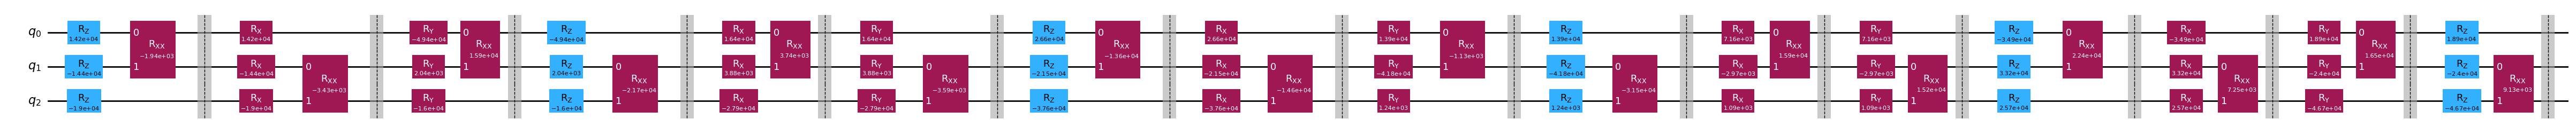

In [27]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl',fold=-1)

In [28]:
psi_final = Statevector(final_ansatz)

In [29]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
qubo_utility = QUBOUtility()
qubo_bitstring = qubo_utility.evaluate_sign_function(psi_final, pauli_strings)
qubo_cost = qubo.objective.evaluate(qubo_bitstring)

print(qubo_bitstring)
print(qubo_cost)

[0, 1, 0, 1, 1, 1, 1, 0, 0]
-72.0


In [30]:
result_initial = converter.interpret(qubo_bitstring)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 72.0
Initial Knapsack solution          : [0. 1. 0. 1. 1.]
Initial Knapsack solution feasible : True


In [31]:
optimized_bitstring, final_cost = qubo_utility.bit_swap_search(qubo, bitstring=qubo_bitstring)
print("Optimized bitstring:", optimized_bitstring)
print("Final cost:", final_cost)

Starting cost: -72.0
Multi-bit flip: Improved solution by flipping bits (0, 1, 5): Cost = -97.0
Multi-bit flip: Improved solution by flipping bits (2, 3, 6): Cost = -114.0
Final best cost: -114.0
Optimized bitstring: [1, 0, 1, 0, 1, 0, 0, 0, 0]
Final cost: -114.0


In [32]:

result_initial = converter.interpret(optimized_bitstring)
initial_cost = problem.objective.evaluate(result_initial)
# check feasibility
inital_feasible = problem.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 114.0
Initial Knapsack solution          : [1. 0. 1. 0. 1.]
Initial Knapsack solution feasible : True
